### 1. Imports

In [2]:
import numpy as np
import cv2
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
from matplotlib import pyplot as plt
import sys
from rayleighsommerfeld02 import rayleighsommerfeld
from scipy.ndimage import map_coordinates
import trackpy as tp
import csv
import os

# adding Folder_2/subfolder to the system path
sys.path.insert(0, '/mnt/d/Experiments/Spring_2022')

from vmedian import vmedian

In [1]:
%gui qt5
from PyQt5.Qt import QApplication
import pyqtgraph as pg

app = QApplication.instance() or QApplication([])

### 2. Load Foreground and get normalized image 

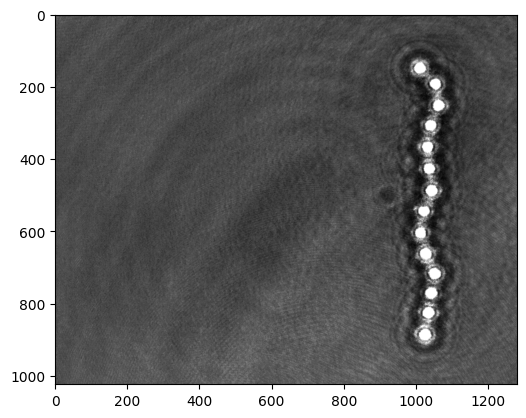

In [980]:
#load foreground to be analyzed
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
tq = 1100
t = str(tq).zfill(4)
fg = plt.imread('./060822/norm_images_14-mer_600/image{}.png'.format(t))
#fg = cv2.cvtColor(fg, cv2.COLOR_BGR2GRAY)

#get background
background = 0
if background:
    a = cv2.VideoCapture('./060822/14-mer_bg.avi', 0)
    ok, b = a.read()
    c = cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)
    med = vmedian(order=2, dimensions=c.shape)

    n = 0
    while ok:
        a.set(cv2.CAP_PROP_POS_FRAMES, n)
        ok, b = a.read()
        if ok:
            c = cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)
            med.add(c)
            n += 5
    bg = med.get()
else:
    bg = 1.

#compute and display normalized image
b = fg/bg

#plt.axis('off')
plt.imshow(b, cmap = 'gray')

### 3. Crop region of interest (512x512)

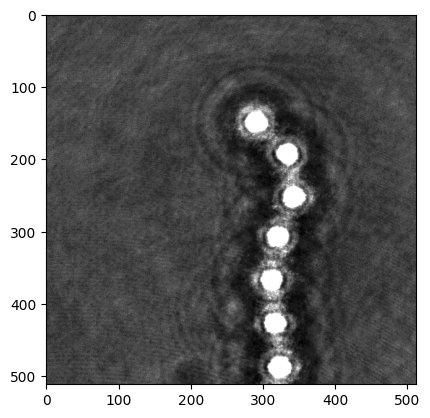

In [981]:
ymin = 0
xmin = 720
d = 512
a = b[ymin:ymin+d,xmin:xmin+d]
plt.imshow(a, cmap = 'gray')

### 3. Perform Rayleigh Sommerfeld 

In [982]:
#perform rayleigh sommerfeld propagation
from timeit import default_timer as timer

zmin = -20 #in um
zmax = 0
n = 400
mpp = 0.048

z = np.linspace(zmin, zmax, n) / mpp #in px

start = timer()
rs = rayleighsommerfeld(a, z, magnification=mpp, nozphase=True)
elapsed_time = timer() - start # in seconds

print(elapsed_time)

bz = np.abs(rs).astype(float)
phi = np.angle(rs - 1.)

19.832942110020667


In [983]:
widget = pg.ImageView()
widget.setImage(bz.T)
widget.show()

### 4. Localize particle of interest manually in 2D (using widget)

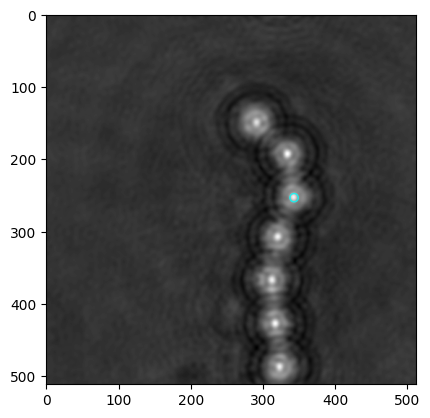

In [987]:
#pull up image to obtain exact (x,y) coordinates
c = bz[:,:,378]
fig, ax = plt.subplots()
ax.imshow(c, cmap = 'gray', alpha = 1.)
x, y = 343, 253
ax.scatter([x], [y], color = 'cyan', facecolors='none', alpha = 0.8)

## 5. Plot I v. z

-1.850


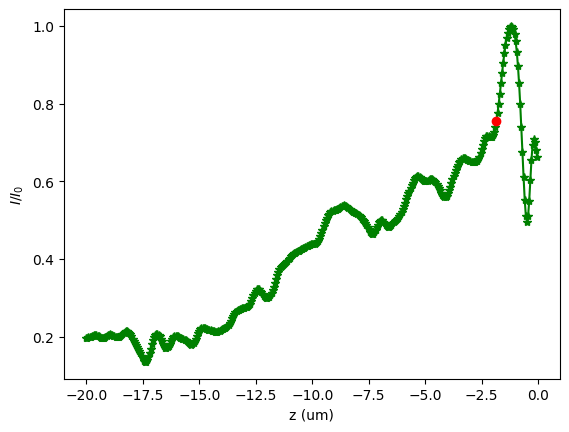

In [988]:
# get amplitude for all z at (x,y)

Y = []
z = []

for i in np.linspace(0, n-1, n):
    i = int(i)
    z.append((zmin + i/n * (zmax - zmin))) #in um
    Y.append(bz[y,x,i])

Y = [y/np.max(Y) for y in Y]    
plt.ylabel(r'$I/I_0$')
plt.xlabel('z (um)')
plt.plot(z,Y,'g*-')

max_Y = np.max(Y)
thresh = 0.25 #within 30% of max values
indexes = [count for count, el in enumerate(Y) if (max_Y-el)/max_Y < thresh]
z_f = z[indexes[0]]
print(format(z_f, ".3f")) #in um

_=plt.plot(z_f, Y[indexes[0]], 'ro')

### 6. Plot $\nabla_{z} I$ v. z

z_p =  -1.6499999999999986
{0: -16.85, 50: -17.35, 100: -17.5, 150: -16.0, 200: -14.100000000000001, 250: -12.35, 300: -10.55, 350: -9.0, 400: -7.9, 450: -6.449999999999999, 500: -5.300000000000001, 550: -4.199999999999999, 600: -3.1000000000000014, 650: -2.75, 700: -2.450000000000003, 750: -2.25, 800: -2.549999999999997, 850: -2.5, 900: -1.8999999999999986, 950: -1.6999999999999993, 1000: -1.6999999999999993, 1050: -1.6499999999999986, 1100: -1.6499999999999986}


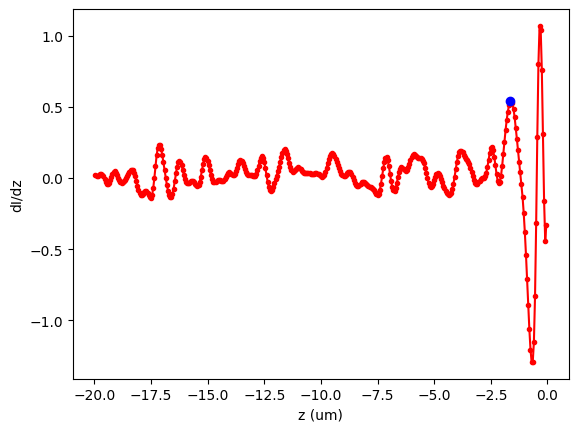

In [990]:
from numpy import diff
dx = 1*(zmax - zmin) / n #in um
dy = diff(Y)/dx #Y is the intensity
plt.plot(z[1:],dy, 'r.-')

sorted_dy = dy.copy()
sorted_dy.sort()
max_val = sorted_dy[-5]#change to -1 if no singularity at center

L = [i for i in range(len(dy)) if dy[i]==max_val]
print('z_p = ', z[L[0]])
plt.ylabel('dI/dz')
plt.xlabel('z (um)')

plt.plot(z[L[0]],dy[L[0]], 'bo')

filename = './060822/polymer_tracking_results/060822_14-mer_600_results_topmiddle3.npy'
#results = {}
results = np.load(filename, allow_pickle = True).item()

results[tq] = z[L[0]]

print(results)

np.save(filename, results)

### 7. Plot full experiment (axial position characterization)

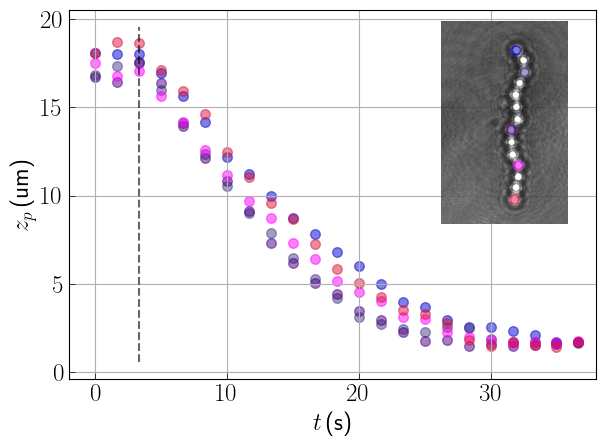

In [991]:
matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family':"sans-serif"})
params = {'text.latex.preamble': [r'\usepackage{siunitx}',\
    r'\usepackage{sfmath}', r'\sisetup{detect-family = true}',\
    r'\usepackage{amsmath}']}  
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots()
ax.grid()

prefix = './060822/polymer_tracking_results/060822_14-mer_600_results'
    
#plot top edge particle trajectories:
results = np.load('{}_top.npy'.format(prefix), allow_pickle = True).item()
#this one datapoint is fake, and left off the plot but used just for the label:
ax.scatter([10000/30], [abs(results[0])], s = 48, edgecolor = 'mediumblue', facecolor = 'mediumblue', alpha = 0.5, label = '1')
for t in results:
    ax.scatter([t/30], [abs(results[t])], s = 48, edgecolor = 'mediumblue', facecolor = 'mediumblue', alpha = 0.5)

    
#plot top-center particle trajectories:
results = np.load('{}_topmiddle3.npy'.format(prefix), allow_pickle = True).item()
#this one datapoint is fake, and left off the plot but used just for the label:
ax.scatter([10000/30], [abs(results[0])], s = 48, edgecolor = 'darkslateblue', facecolor = 'darkslateblue', alpha = 0.5, label = '3')
for t in results:
    ax.scatter([t/30], [abs(results[t])], s = 48, edgecolor = 'darkslateblue', facecolor = 'darkslateblue', alpha = 0.5)
    
#plot middle particle trajectories:
results = np.load('{}_middle.npy'.format(prefix), allow_pickle = True).item()
#this one datapoint is fake, and left off the plot but used just for the label:
ax.scatter([10000/30], [abs(results[0])], s = 48, edgecolor = 'indigo', facecolor = 'indigo', alpha = 0.5, label = '5')
for t in results:
    ax.scatter([t/30], [abs(results[t])], s = 48, edgecolor = 'indigo', facecolor = 'indigo', alpha = 0.5)
    
#plot bottom-center particle trajectories:
results = np.load('{}_bottommiddle.npy'.format(prefix), allow_pickle = True).item()
#this one datapoint is fake, and left off the plot but used just for the label:
ax.scatter([10000/30], [abs(results[1100])], s = 48, edgecolor = 'magenta', facecolor = 'magenta', alpha = 0.5, label = '7')
for t in results:
    ax.scatter([t/30], [abs(results[t])], s = 48, edgecolor = 'magenta', facecolor = 'magenta', alpha = 0.5)
    
#plot bottom particle trajectories:
results = np.load('{}_bottom.npy'.format(prefix), allow_pickle = True).item()
#this one datapoint is fake, and left off the plot but used just for the label:
ax.scatter([10000/30], [abs(results[0])], s = 48, edgecolor = 'crimson', facecolor = 'crimson', alpha = 0.5, label = '10')
for t in results:
    ax.scatter([t/30], [abs(results[t])], s = 48, edgecolor = 'crimson', facecolor = 'crimson', alpha = 0.5)
    

ax.set_xlabel(r'$t$\,(s)')
ax.set_ylabel(r'$z_p$\,(um)')
ax.set_xlim(right=38)
ax.set_xlim(left=-2)
#ax.set_ylim(bottom=1.0)

#add inset for label
b = plt.imread('./060822/norm_images_14-mer_600/image{}.png'.format(1000))
ins = ax.inset_axes([0.55,0.42,0.55,0.55])
ins.imshow(b[0:1000,656:1280], cmap = 'gray', alpha = 0.9)
ins.scatter([366], [140], s = 48, edgecolor = 'mediumblue', facecolor = 'mediumblue', alpha = 0.5)
ins.scatter([412], [250], s = 48, edgecolor = 'darkslateblue', facecolor = 'darkslateblue', alpha = 0.5)
ins.scatter([345], [530], s = 48, edgecolor = 'indigo', facecolor = 'indigo', alpha = 0.5)
ins.scatter([381], [712], s = 48, edgecolor = 'magenta', facecolor = 'magenta', alpha = 0.5)
ins.scatter([360], [875], s = 48, edgecolor = 'crimson', facecolor = 'crimson', alpha = 0.5)
ins.axis('off')



#ins.axis('off')
#ins.imshow(b, cmap = 'gray')

#ax.legend()    

bot, top = ax.get_ylim()
ax.plot([3.33,3.33],[bot,top], 'k--', alpha = 0.6)
ax.tick_params(direction='in', length=4, width=0.5)
#ax.set_title('Exp: 060822, 10-mer_z+600')

plt.tight_layout()
plt.savefig('./060822/polymer_tracking_results/060822_14-mer_600_sedimentation03.png', dpi = 600)

plt.show()

### 8. Plot the difference between left end and middle end

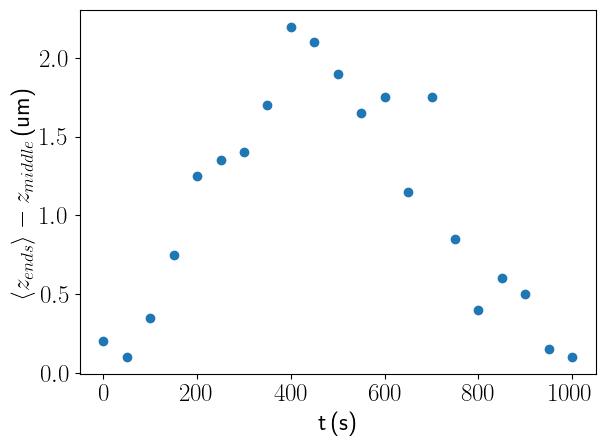

In [1122]:
middle = np.load('./053122/polymer_tracking_results/041322_12-mer_750_results_middle.npy', allow_pickle = True).item()
left = np.load('./053122/polymer_tracking_results/041322_12-mer_750_results_left_end.npy', allow_pickle = True).item()
right = np.load('./053122/polymer_tracking_results/041322_12-mer_750_results_right_end.npy', allow_pickle = True).item()

fig,ax = plt.subplots()
dif = []
t = []
for k in middle:
    t.append(k)
    mid = abs(left[k])/2 + abs(right[k])/2
    dif.append(mid-abs(middle[k]))
ax.scatter(t, dif)
ax.set_ylabel(r'$\langle z_{ends}\rangle - z_{middle}$\,(um)')
ax.set_xlabel(r't\,(s)')
plt.tight_layout()
plt.savefig('041322_axial_separation.png', dpi = 400)